In [1]:
# IMPORTS
from DbManager import DbManager
from DataManager import DataManager
from DataCleaner import DataCleaner
from DataVisualiser import DataVisualiser
from DataAnalyser import DataAnalyser

import sqlite3
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import dateutil
from math import pi
from datetime import datetime, timedelta
import random
import calendar

from bokeh.plotting import figure, show, ColumnDataSource, vplot
from bokeh.io import output_notebook
from bokeh.charts import TimeSeries, show, output_file, vplot, Line
from bokeh.models import DatetimeTickFormatter, HoverTool
from bokeh.models.widgets import Panel, Tabs
from bokeh.palettes import brewer
from bokeh.charts import Bar
from bokeh.charts.attributes import cat

output_notebook() 
%matplotlib inline

Loading BokehJS ...

## Basic statistics on each counter, given the daily time-series
This computes measures such as:
- minimum daily value
- maximum daily value
- daily average
- standard deviation of daily values

In [4]:
counterIds = [(cid.encode('ascii'), name.encode('ascii')) for cid,name,noCh in DbManager.getAllCountersIdentifiers()]
countersStats = pd.DataFrame(index = [cId + '-' + name for cId, name in counterIds], 
                               columns = ['counterId', 'min', 'max', 'mean','std', 'percent'])

total = 0
# Get total for percentage calculation
for counter in counterIds:
    data = DbManager.getProcessedDataForCounter(counter[0])
    data = DataManager.getSampledData(data, "daily", "sum")
    data['allChannels'] = data.mean(axis=1)
    total += data['allChannels'].mean()

print total

# Compute basic statistics for all counters
for counter in counterIds:
    data = DbManager.getProcessedDataForCounter(counter[0])
    data = DataManager.getSampledData(data, "daily", "sum")
    data['allChannels'] = data.mean(axis=1)

    countersStats.set_value(counter[0] + '-' + counter[1], 'counterId', counter[0])
    countersStats.set_value(counter[0] + '-' + counter[1], 'min', round(data['allChannels'].min(), 2))
    countersStats.set_value(counter[0] + '-' + counter[1], 'max', round(data['allChannels'].max(), 2))
    countersStats.set_value(counter[0] + '-' + counter[1], 'mean', round(data['allChannels'].mean(), 2))
    countersStats.set_value(counter[0] + '-' + counter[1], 'std', round(data['allChannels'].std(), 2))
    countersStats.set_value(counter[0] + '-' + counter[1], 'percent', 
                            round(data['allChannels'].mean() * 100 / float(total), 2))

print countersStats[['min', 'max', 'mean', 'std', 'percent']]

6984.52251277
                                         min      max    mean     std percent
01-Peffermill Road                         0    31.75    8.47    3.76    0.12
02-Steadfastgate                           0      337  121.39   57.15    1.74
03-Hawkhill Avenue                         0  3903.75   48.55  248.14     0.7
04-Seafield Street                         0      142   43.76   24.59    0.63
05-Blackhall                               0     2481   220.6  149.34    3.16
06-Silverknowes                            0      180   49.25    35.8    0.71
07-Westercoates                            0     2259  276.57  139.58    3.96
08-Forth Road Bridge                       0   4756.5    54.6  107.03    0.78
09-Queensferry - Dalmeny                   0       65   14.66   10.89    0.21
10-RBS Gogar                               0      132   36.01   19.87    0.52
11-Innocent                                0    703.5  155.53   70.95    2.23
12-Cultins Road                            0      

#### Statstistic over all counters

In [3]:
print "Minimum daily value across all counters is: " + str(countersStats['min'].min()) 
print "Maximum daily value across all counters is: " + str(countersStats['max'].max()) 
print "Mean value across all counters is: " + str(countersStats['mean'].mean())

Minimum daily value across all counters is: 0.0
Maximum daily value across all counters is: 4756.5
Mean value across all counters is: 151.83673913


## Cross-counter analysis of patterns

### Overall average per counter (mean of values from the aggregated channel)

In [4]:
# Clean data for each counter and store it in the database
counterIds = [(cid.encode('ascii'), name.encode('ascii')) for cid,name,noCh in DbManager.getAllCountersIdentifiers()]

countersAverage = pd.DataFrame(index = [cId + '-' + name for cId, name in counterIds], columns = ['avgCount'])
for counter in counterIds:
    data = DbManager.getProcessedDataForCounter(counter[0])
    data = DataManager.getSampledData(data, "daily", "sum")
    countersAverage.set_value(counter[0] + '-' + counter[1], 'avgCount', data.mean(axis=0).mean())

### Bar-chart showing average of each counter is descending order, along with the overall cross-counter mean

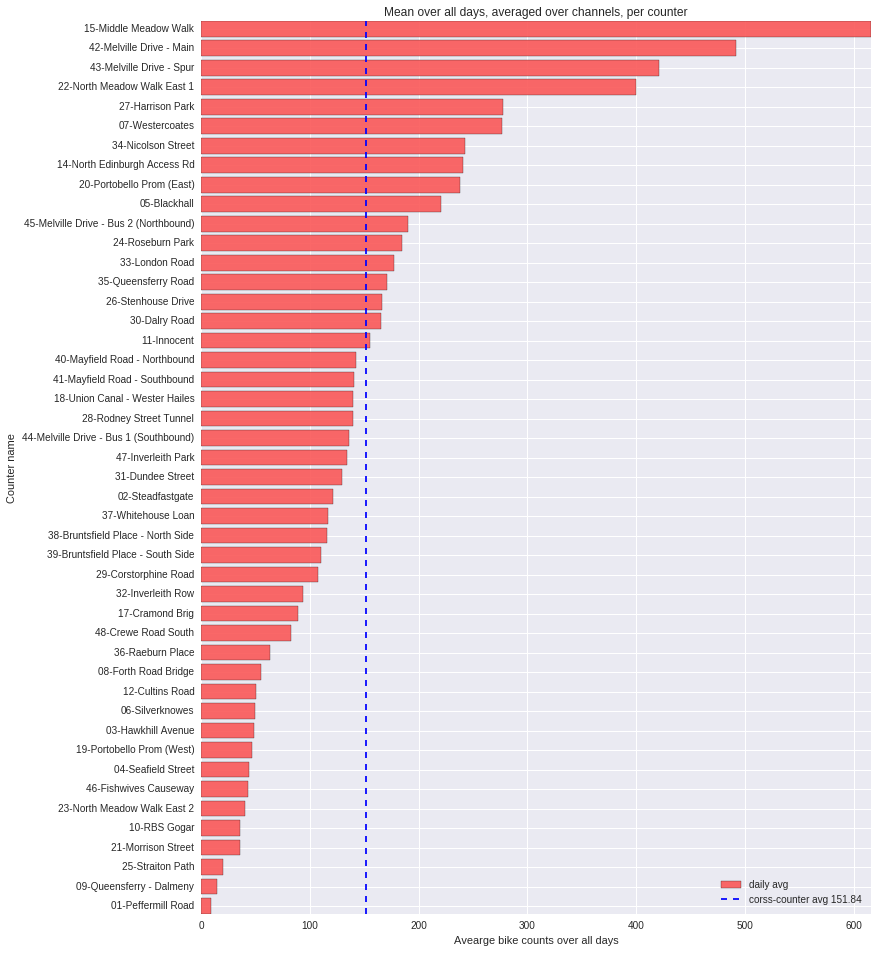

<module 'matplotlib.pyplot' from '/home/andreea/.local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [5]:
countersAverage = countersAverage.sort_values(by='avgCount')

def showCounterAverage(counterAndMean, dim=None):
    if dim is None:
        dim = (DataVisualiser._pltFigsize[0],DataVisualiser._pltFigsize[1])
    fig = plt.figure(figsize=(dim[0], dim[1]))

    y_pos = np.arange(countersAverage.shape[0])

    b = plt.barh(y_pos, countersAverage['avgCount'], align='center', color = '#FA5858', alpha=0.9)
    m = plt.axvline(x = countersAverage['avgCount'].mean(), linestyle = "--")
    plt.legend((b,m), ('daily avg', 'corss-counter avg ' + "%0.2f" % countersAverage['avgCount'].mean()), 
               loc='lower right')
    plt.axis('tight')
    plt.yticks(y_pos, countersAverage.index)
    plt.title('Mean over all days, averaged over channels, per counter')
    plt.xlabel('Avearge bike counts over all days')
    plt.ylabel('Counter name')
    plt.show()
    return plt

showCounterAverage(countersAverage, dim = (12, 16))

### Clustering of counters

#### Preparation of a pivot table:
- each counter is described by a 12-D feature vector
- each feature is a daily for each month of the year

In [8]:
counterIds = [(cid.encode('ascii'), name.encode('ascii')) for cid,name,noCh in DbManager.getAllCountersIdentifiers()]

countersMonthly = pd.DataFrame()
for counter in counterIds:
    data = DataManager.getReindexedCleanDataFor(counter[0])
    data['allChannels'] = data.mean(axis=1)
    data = DataManager.fillMissingData(data['allChannels'])
    data = DataManager.getSampledData(data, "daily", "sum")
    
    data.columns = ['counts']
    data['month'] = data.index.month
    
    # aggregated data by month
    aggData = data.groupby('month').aggregate(np.mean)
    aggData['counterId'] = counter[0]
    aggData['month'] = aggData.index  
      
    if countersMonthly.empty:
        countersMonthly = aggData.copy()
    else:
        countersMonthly = pd.concat([countersMonthly, aggData])

pivotedTbl = countersMonthly.pivot(index='counterId', columns='month', values='counts')
pivotedTbl = pivotedTbl.fillna(0)

###  Plotting clustered counters and their daily avearge

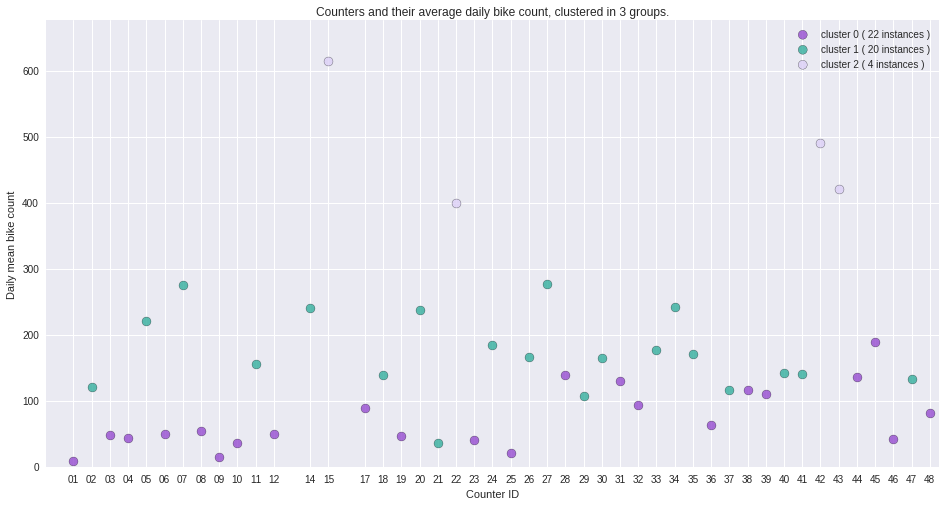

Cluster 0 - mean of cluster is 72.9222727273
Cluster 1 - mean of cluster is 172.5875
Cluster 2 - mean of cluster is 482.1125


In [12]:
clustNo = 3
cluster_label = DataAnalyser.clusterData(pivotedTbl, clustNo)

# define different colors for each cluster
col = []
for ind in range(clustNo):
    col.append("#%06x" % random.randint(0, 0xFFFFFF))

# create dataframe for plotting 
clDF = pd.DataFrame(index = pivotedTbl.index, data = cluster_label, columns = ['cluster'])
clDF['intCounter'] = [int(x) for x in clDF.index]
clDF['meanCounts'] = [countersStats[countersStats['counterId'] == cId]['mean'][0] for cId in clDF.index] 

def plotCountersAsClusters(clusteredData, clustNo):
    fig = plt.figure(figsize=(16, 8)) 
    for ind in range(clustNo):
        clusterSpecific = clusteredData[clusteredData['cluster'] == ind]
        plt.scatter(clusterSpecific.intCounter, clusterSpecific.meanCounts, 
                    s=80, alpha = 0.8, c = col[ind], 
                    label = 'cluster ' + str(ind) + ' ( ' + str(len(clusterSpecific)) + ' instances )')
    plt.xticks(clusteredData.intCounter.values, clusteredData.index)
    plt.xlim([- 0.5, clusteredData.intCounter.values.max() + 0.5])
    plt.ylim([0, clusteredData.meanCounts.values.max() + clusteredData.meanCounts.values.max()/10])
    plt.xlabel('Counter ID')
    plt.ylabel('Daily mean bike count')
    plt.title("Counters and their average daily bike count, clustered in " + str(clustNo) + " groups.")
    plt.legend()
    return plt

plotCountersAsClusters(clDF, clustNo).show()

for ind in range(clustNo):
    clusterSpecific = clDF[clDF['cluster'] == ind]
    print 'Cluster ' + str(ind) + ' - mean of cluster is ' + str(clusterSpecific['meanCounts'].mean())

### Adding geographical information for enriched visualisations

In [13]:
counterIds = [(cid.encode('ascii'), name.encode('ascii')) for cid,name,noCh in DbManager.getAllCountersIdentifiers()]

cDetails = pd.DataFrame()
for counter in counterIds:
    if cDetails.empty:
        cDetails = DbManager.getSpecificCounterDetails(counter[0])
    else:
        cDetails = pd.concat([cDetails, DbManager.getSpecificCounterDetails(counter[0])])

cDetails.index = cDetails['counter_id']
cDetails = cDetails[['latitude', 'longitude']]
cDetails['latitude'] = [float(lat) for lat in cDetails['latitude']]
cDetails['longitude'] = [float(lon) for lon in cDetails['longitude']]

### Plot counters according to their location, cluster membership

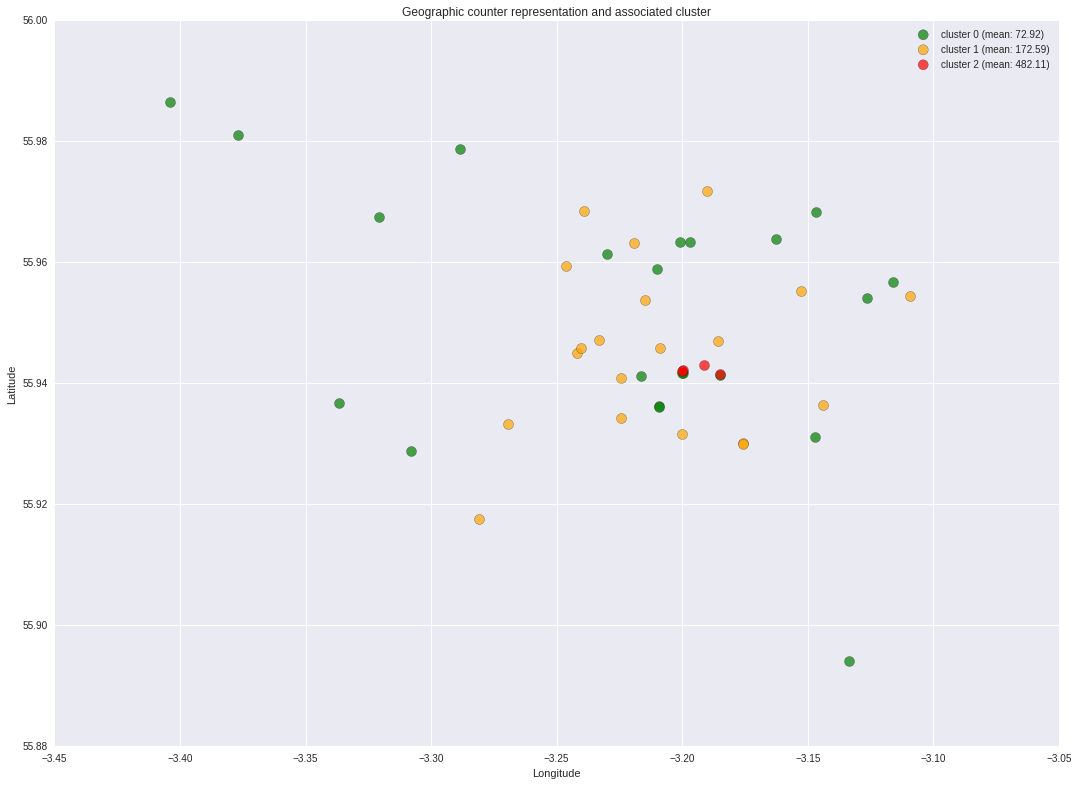

In [15]:
# Plot counters
tempData = pd.DataFrame(index = pivotedTbl.index)
tempData['totalMean'] = [countersStats[countersStats['counterId'] == cId]['mean'][0] for cId in tempData.index]
tempData['cluster'] = cluster_label

tempData = clDF.join(cDetails)

def showCounterCluster(clusterData, dim=None):
    if dim is None:
        dim = (DataVisualiser._pltFigsize[0],DataVisualiser._pltFigsize[1])
    fig = plt.figure(figsize=(dim[0], dim[1]))
    
    clusterAgg = clusterData[['cluster', 'meanCounts']].groupby('cluster').aggregate(np.mean)
    
    col = ['green', 'orange', 'red']
                
    for c in clusterAgg.index:
        clusterSpecific = clusterData[clusterData['cluster'] == c]
        plt.scatter(clusterSpecific['longitude'], clusterSpecific['latitude'],
                s=100, alpha = 0.7,
                c = col[c],
                label = 'cluster ' + str(c) + ' (mean: ' + '%.2f' % clusterAgg.loc[c].values[0] + ')')    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title("Geographic counter representation and associated cluster")
    plt.legend()
    return plt

showCounterCluster(tempData, dim=(18,13)).show()

### Geograhical hexagonal binning, displaying area popularity according to counter traffic volume

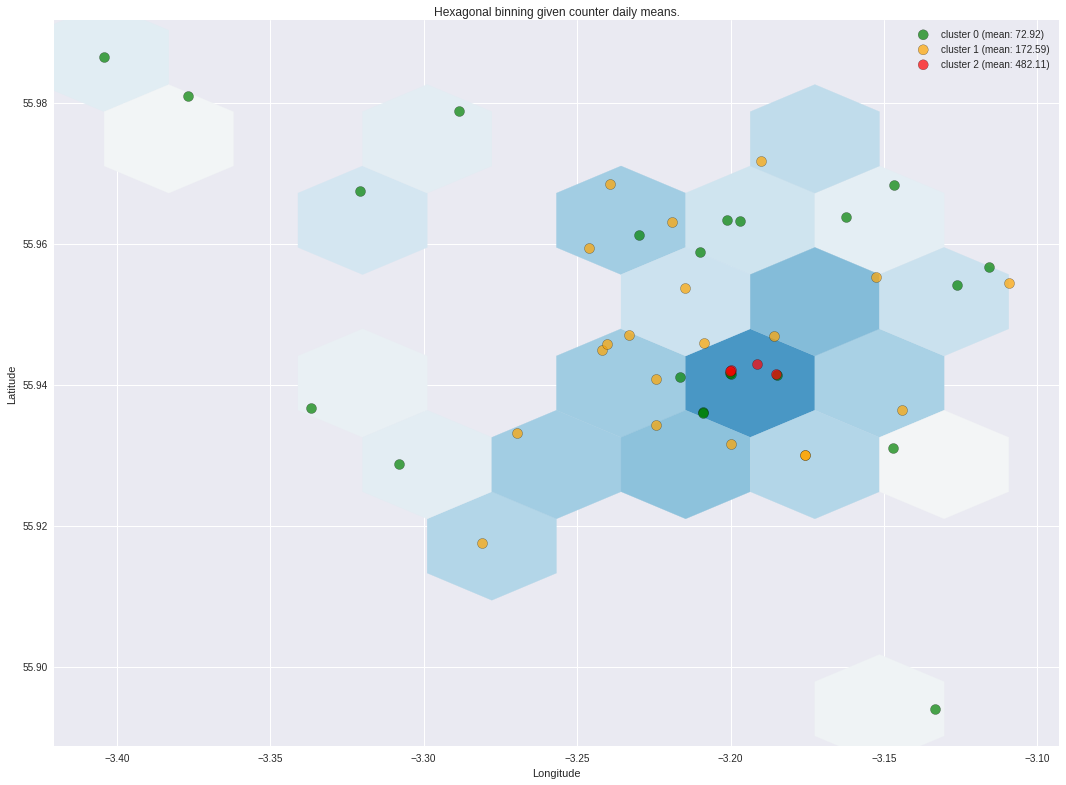

In [16]:
def showConterAreasAsHex(clusterData,  dim=None):
    if dim is None:
        dim = (DataVisualiser._pltFigsize[0],DataVisualiser._pltFigsize[1])
    fig = plt.figure(figsize=(dim[0], dim[1]))

    clusterAgg = tempData[['cluster', 'meanCounts']].groupby('cluster').aggregate(np.mean)
    clusterData['clusterMean'] = [clusterAgg[clusterAgg.index == cl]['meanCounts'][cl] for cl in clusterData['cluster']]
    
    plt.hexbin(clusterData['longitude'], clusterData['latitude'], C=clusterData['meanCounts'], 
           gridsize=7,cmap=plt.cm.RdBu, 
           vmax=abs(clusterData['clusterMean']).max(), vmin=-abs(clusterData['clusterMean']).max(),
           label = '') 
    
    col = ['green', 'orange', 'red']

    for c in clusterAgg.index:
        clusterSpecific = clusterData[clusterData['cluster'] == c]
        plt.scatter(clusterSpecific['longitude'], clusterSpecific['latitude'],
                s=100, alpha = 0.7,
                c = col[c],
                label = 'cluster ' + str(c) + ' (mean: ' + '%.2f' % clusterAgg.loc[c].values[0] + ')')  
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Hexagonal binning given counter daily means.')
    plt.legend()
    return plt

showConterAreasAsHex(tempData, dim=(18,13)).show()